### Dataset from Waterstones.com
### Classifiction model predicting fiction/non_fiction based on description


In [124]:
# import all necessary libraries
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [125]:
df = pd.read_pickle('class_data.pkl')  ### read data into dataframe

In [126]:
df

,title,categories,description,fiction
0,Optical Studies in Liquids and Solids,"Science, Technology & Medicine",The study of the vibrations of polyatomic mole...,False
1,Economics with Connect Plus Card,"Business, Finance & Law",The combination of David Begg with new co-auth...,False
2,"Scoring High on SAT, Teacher Edition Grade 6","Politics, Society & Education",Teacher Edition,False
3,Teaching Anticorruption,"Business, Finance & Law",The movement in management education towards a...,False
4,Learning Organizations,"Business, Finance & Law",Learning Organizations: Turning Knowledge into...,False
...,...,...,...,...
45121,Whio,"Science, Technology & Medicine","The blue duck, or whio, is one of New Zealand'...",False
45122,Northern Irish Poetry,"Poetry, Drama & Criticism",Through discussion of the ways in which major ...,True
45123,"Reviews of Physiology, Biochemistry and Pharma...","Science, Technology & Medicine",W. Ulbricht: Effects of veratridine on sodium ...,False
45124,The Vital Needs Of The Dead By Igor Sakhnovsky,Fiction,The Vital Needs of the Dead is a tender coming...,True


### Text classification can be divided in two stages. 
Stages are training and testing. During the training phase, the documents are pre-processed and are conditioned by a 
learning algorithm to create a classifier. Validation of the classifier is done in the testing stage. Support Vector 
Machines (SVM), K-Nearest Neighbor (K-NN), Logistic Regression (LR), and other conventional learning 
algorithms can all be used to train the data

### Cleaning the text

In [127]:
def clean_text(text):   ### create a function to clean the text from description
    text = re.sub("\''", "", text) ## this escapes the single quatos
    text = re.sub("[^a-zA-Z]", " ", text) ### find all the alphabet letter, both uppercase and lowercase
    text = ' '.join(text.split())  ### join single word togather as a string
    text = text.lower()  ### take the lowercase of all words
    return text

In [128]:
df['clean_des'] = df['description'].apply(lambda x: clean_text(x))   ### clean the description

In [129]:
def fre_words(x, terms):   #### Check 
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df =pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    d = words_df.nlargest(columns='count', n = terms)
    plt.figure(figsize=(20, 20))
    ax = sns.barplot(data=d, x='count', y='word')
    ax.set(ylabel = 'word')
    plt.show()

## Feature extraction using TFIDF

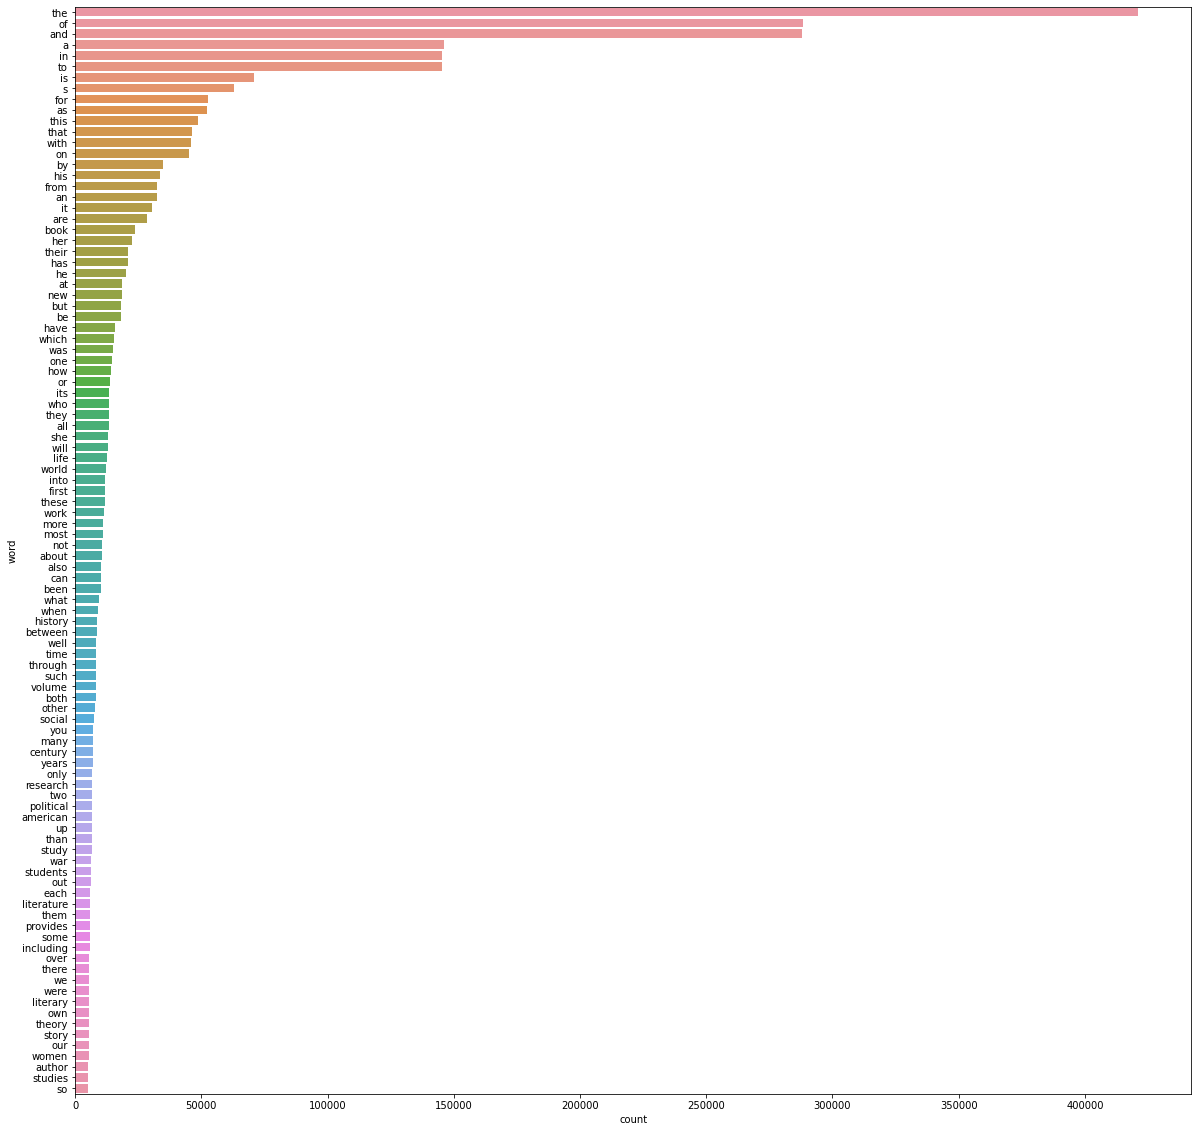

In [130]:
fre_words(df['clean_des'], 100)

In [145]:
target = pd.DataFrame(df['fiction'])
f = lambda x: 1 if x==True else 0
target = target.applymap(f)

In [146]:
target

,fiction
0,0
1,0
2,0
3,0
4,0
...,...
45121,0
45122,1
45123,0
45124,1


In [147]:
X = df['clean_des'] ## feature column
y = target['fiction']  ## target column

In [149]:
tf = TfidfVectorizer(max_df=0.1, stop_words=ENGLISH_STOP_WORDS)
X = tf.fit_transform(X)

In [137]:
from sklearn.model_selection import cross_val_score
dt = DecisionTreeClassifier()
accuracy = cross_val_score(dt, X, y, scoring='accuracy', cv=5)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:", accuracy.mean() * 100)

[0.85453135 0.84033241 0.86526316 0.84421053 0.84376731]
Accuracy of Model with Cross Validation is: 84.96209522137647


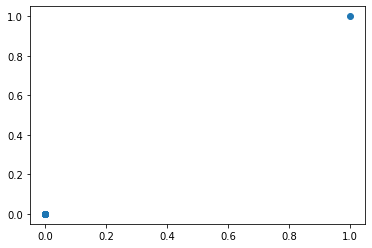

In [152]:
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(dt, X, y, cv=5)
plt.scatter(predictions[:10], y[:10])

### Spliting the data set

In [105]:
print(f"Number of samples in dataset: {len(X)}")   ####Here imported train_test_spllit function from sklearn.model_selection function to train model. this model includes x_train value as the features extracted from clean abstract and x_test as genres of book to be classified. x_validation for hyperparamter tuning

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_validation, y_test, y_validation = train_test_split(
    X_test, y_test, test_size=0.5
)

print("Number of samples in:")
print(f"    Training: {len(y_train)}")
print(f"    Validation: {len(y_validation)}")
print(f"    Testing: {len(y_test)}")

Number of samples in dataset: 45126
Number of samples in:
    Training: 31588
    Validation: 6769
    Testing: 6769


### Fit the text normalisaitn vector

In [106]:
tf = TfidfVectorizer(max_df=0.1, stop_words=ENGLISH_STOP_WORDS)
#TfidVectorizer function from sklearn library is used to extract features from abstract and assigning weights to the feature values.  max_df used for removing terms that appear too frequently

In [107]:
X_train_tf = tf.fit_transform(X_train)##This trained model uses Tfidfvectorizer to assign weight of features to genr
X_test_tf = tf.transform(X_test)  ### transform to X_test dataset
X_validation_tf = tf.transform(X_validation)

### Try ML models

In [108]:
knn=KNeighborsClassifier(n_neighbors=29, weights='distance')  ### Create a knn classifier
knn.fit(X_train_tf, y_train)  ### fit on train data set
  ### make predictions on data set

y_train_pred = knn.predict(X_train_tf) ### create knn cassifier
y_validation_pred = knn.predict(X_validation_tf)
print(knn)
print('train loss:',metrics.log_loss(y_train, y_train_pred))### perfrom binary cross entropy for three data set
print('validation loss: ', metrics.log_loss(y_validation, y_validation_pred))

KNeighborsClassifier(n_neighbors=29, weights='distance')
train loss: 0.06997867819611549
validation loss:  4.306522324672986


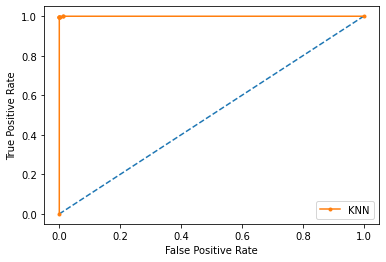

In [109]:
from sklearn.metrics import  roc_curve   ###  plot Roc Curve
# predict probabilities
yhat = knn.predict_proba(X_train_tf)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='KNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot

In [119]:
#hyperparameter tuning for knn
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy') ### using GridSearchCV method
grid.fit(X_validation_tf, y_validation)


print(grid.best_score_)
print(grid.best_params_) ### 
print(grid.best_estimator_)

0.8940760665309011
{'n_neighbors': 29, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=29, weights='distance')


In [110]:
#Create a svm Classifier
from sklearn.calibration import CalibratedClassifierCV
svc = LinearSVC(random_state=0)
clf = CalibratedClassifierCV(svc) 
clf.fit(X_train_tf, y_train)

y_train_pred = clf.predict(X_train_tf)
y_validation_pred = clf.predict(X_validation_tf)
print(svc)
print('train loss:',metrics.log_loss(y_train, y_train_pred))### perfrom binary cross entropy 
print('validation loss: ', metrics.log_loss(y_validation, y_validation_pred))

#Predict the response for dataset

LinearSVC(random_state=0)
train loss: 0.28757094292653673
validation loss:  2.000200246521857


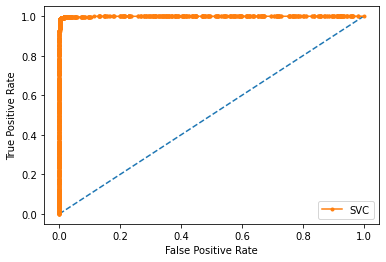

In [114]:
from sklearn.metrics import  roc_curve   ###  plot Roc Curve
# predict probabilities
yhat = clf.predict_proba(X_train_tf)[:, 1]# keep probabilities for the positive outcome only

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='SVC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot

In [116]:
logreg = LogisticRegression() ### Create a logistic regression
logreg.fit(X_train_tf, y_train)
y_train_pred = logreg.predict(X_train_tf)
y_validation_pred = logreg.predict(X_validation_tf)

print(logreg)
print('train loss:',metrics.log_loss(y_train, y_train_pred))## perfrom binary cross entropy 
print('validation loss: ', metrics.log_loss(y_validation, y_validation_pred))

LogisticRegression()
train loss: 1.3700673205298137
validation loss:  2.107357210415032


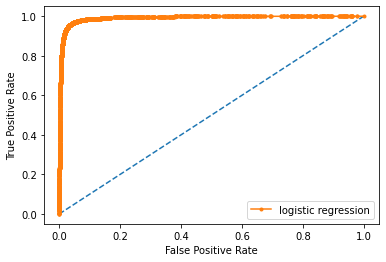

In [117]:
from sklearn.metrics import  roc_curve   ###  plot Roc Curve
# predict probabilities
yhat = logreg.predict_proba(X_train_tf)[:, 1]# keep probabilities for the positive outcome only

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='logistic regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot

In [121]:
dt = DecisionTreeClassifier()

 ###  Measure the success

 Threshold moving

Best Threshold=0.484024, F-Score=0.943


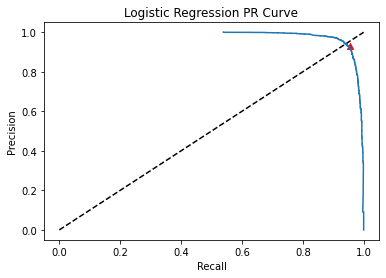

In [60]:
from sklearn.metrics import  precision_recall_curve
y_pred_prob = logreg.predict_proba(X_test_tf)[:,1]
precision, recall, thresholds =  precision_recall_curve(y_test, y_pred_prob)####Running the example first calculates the Fscore for each threshold, then locates the score and threshold with the largest value.
    
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
best_thresh = thresholds[ix]

plt.plot([0, 1], [0, 1],'k--')
plt.plot(precision, recall, label='Logistic Regression')

plt.scatter(recall[ix], precision[ix], marker='^', color='red', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression PR Curve')
plt.show()


In [29]:
predictions = np.where(y_pred_prob > best_thresh,True,False)  ### use the best threshold to find best predcition and preform metrics on that

### Output evalution

In [57]:
def print_metrics(model, y_test, y_pred):
    print(model)  ### This function preform model evaluation
    print('confusion_matrix: \n', confusion_matrix(y_test, y_pred))
    print('binary cross entropy: ', metrics.log_loss(y_test, y_pred)) ## to see any changes in the log loss, loss decreased 0.05, which is good
    print('accuracy: ', metrics.accuracy_score(y_test, y_pred))  ### caculate accurary score
print_metrics(logreg, y_test, predictions)

LogisticRegression()
confusion_matrix: 
 [[3078  243]
 [ 153 3295]]
binary cross entropy:  2.0206160074693713
accuracy:  0.9414980056138278


### Show the examples of true lable and prediction

In [32]:
def infer_tags(q, model):  ###  This function showing the output of the prediction 
    q = q.apply(lambda x: clean_text(x))
    q = [word for words in q[:2].str.split() for word in words if word not in ENGLISH_STOP_WORDS]    ## remove stopwords like "the","that","a" words
    q = [" ".join(q)]
    q_vec = tf.transform(q)
    q_pred = model.predict(q_vec)
    return q_pred

In [34]:
for i in range(5):  ###  show 5 predcition examples from SVM classifier, compare with actual lables
    sam = X_test.sample(1)
    k = sam.index
    
    print('Title:', df['title'][k], 'predcition: ', infer_tags(sam, svc), 'Actual: ', df['fiction'][k])

Title: 34118    A Study Book for the NEBOSH National Diploma
Name: title, dtype: object predcition:  [False] Actual:  34118    False
Name: fiction, dtype: bool
Title: 34049    Molecular Pain
Name: title, dtype: object predcition:  [False] Actual:  34049    False
Name: fiction, dtype: bool
Title: 24308    The File on Lester
Name: title, dtype: object predcition:  [ True] Actual:  24308    True
Name: fiction, dtype: bool
Title: 2353    Knowledge and Money
Name: title, dtype: object predcition:  [False] Actual:  2353    False
Name: fiction, dtype: bool
Title: 778    Diaspora and Visual Culture
Name: title, dtype: object predcition:  [False] Actual:  778    False
Name: fiction, dtype: bool


In [23]:
for i in range(5): ###  show 5 predcition examples from Losist Regression classifier, compare with actual lables
    sam = X_test.sample(1)
    k = sam.index
    
    print('Title:', df['title'][k], 'predcition: ', infer_tags(sam, logreg), 'Actual: ', df['fiction'][k])

Title: 21744    Shakespeare and the Eighteenth Century
Name: title, dtype: object predcition:  [ True] Actual:  21744    True
Name: fiction, dtype: bool
Title: 31576    Optimizing Emergency Department Throughput
Name: title, dtype: object predcition:  [False] Actual:  31576    False
Name: fiction, dtype: bool
Title: 37663    Love and Other Dangerous Chemicals
Name: title, dtype: object predcition:  [ True] Actual:  37663    True
Name: fiction, dtype: bool
Title: 28856    The Harlem Renaissance
Name: title, dtype: object predcition:  [ True] Actual:  28856    True
Name: fiction, dtype: bool
Title: 15546    Love and Strange Horses
Name: title, dtype: object predcition:  [ True] Actual:  15546    True
Name: fiction, dtype: bool


0.8949632034821218
{'n_neighbors': 29, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=29, weights='distance')
